# Comparison with tSNE and UMAP
This notebook applies the Sequencer, tSNE, and UMAP to a simple simulated dataset and compares the Sequencer result to the one-dimensional embedding by tSNE and UMAP. It can be divided into three main parts: <br>
1. **Simulating the dataset:** I first start by simulating a dataset consisting of 1D objects with structured and random fluctuations on a range of scales. <br>
2. **Figure of merit for the one-dimensional embedding by tSNE and UMAP:** in this part I show how we use the graph axis ratio to define a general figure of merit for the one-dimensional embedding of any Dimensionality Reduction algorithm. In particular, I show how this new figure of merit can be used to optimize the hyper-parameters of algorithms such as tSNE and UMAP. <br>
3. **Comparison between the Sequencer and tSNE and UMAP:** here I apply the three algorithms to the simulated dataset and compare their one-dimensional embeddings. 

### Environment setup
Before we start, we need to make sure that all the required packages are installed. <br>
If you did not install the required packages, then you should either follow the instructions from the [README](https://github.com/dalya/Sequencer/blob/master/README.md) file, or you should uncomment the following cell:

In [1]:
#!conda install numpy scipy networkx matplotlib scikit-learn
#!pip install umap-learn
#!pip install TheSequencer

In [2]:
# imports
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import wasserstein_distance
import umap

import sequencer

## 1. Simulating a dataset with a clear one-dimensional sequence

In this part of the notebook I will construct a simple dataset with small-scale and large-scale fluctuations. <br>
The dataset will consist of 200 1D objects, each with 400 pixels. The large-scale fluctuations are modeled with a Gaussian process with a squared exponential covariance function: $C(x, x') = \exp{} \Big[(x - x')^{2}/2h^{2} \Big]$, with $h$ drawn from a uniform distribution $U(1, 100)$. This broad range in $h$ ensures that the large-scale variation of each of the objects will be on very different scales. In addition, I add Gaussian iid noise to each of the pixels. The one-dimensional trend is modeled using four narrow pulses with varying locations. 

(200, 400)


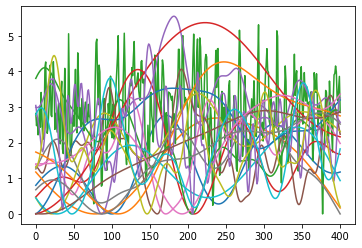

In [4]:
# start by constructing the continuum fluctuations on small and large scales
def squared_exponential(x1, x2, h):
    return numpy.exp(-0.5 * (x1 - x2) ** 2 / h ** 2)

numpy.random.seed(1)
x = numpy.linspace(0, 400, 400)
mu = numpy.zeros(len(x))

draws = []
h_list = numpy.random.uniform(1, 100, 200)
for h_val in h_list:
    C = squared_exponential(x, x[:, None], h_val)
    draw_val = numpy.random.multivariate_normal(mu, C, 1).flatten()
    draws.append(draw_val)
    
draws = numpy.array(draws)
print(draws.shape)

# plot 20 examples
for i in range(20):
    plt.plot(x, draws[i] - numpy.min(draws[i]))

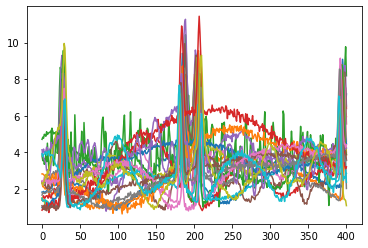

In [6]:
# construct the synthetic dataset by adding narrow pulses that form a clear 1D sequence, and add some iid noise

# narrow pulses properties
mu_list_1 = numpy.linspace(25*2, 50*2, 200) - 25
mu_list_2 =  numpy.linspace(190, 90, 200)
mu_list_3 = numpy.linspace(100*2, 150*2, 200)
mu_list_4 = numpy.linspace(400, 150*2, 200)
sigma_val = 2.

objects_list = []
for i in range(200):
    # define the continuum
    continuum_val = draws[i]
    continuum_pos = continuum_val - numpy.min(continuum_val)
    
    # define iid Gaussian noise that you will add to these objects
    noise = numpy.random.normal(loc=0, scale=0.1 * numpy.std(continuum_pos), size=len(continuum_pos))
    
    # define the narrow pulses
    mu_val_1 = mu_list_1[i]
    mu_val_2 = mu_list_2[i]
    mu_val_3 = mu_list_3[i]
    mu_val_4 = mu_list_4[i]
    narrow_pulses = 5 * numpy.exp(-(mu_val_1 - x)**2/(2*sigma_val**2)) + \
                    5 * numpy.exp(-(mu_val_2 - x)**2/(2*sigma_val**2)) + \
                    5 * numpy.exp(-(mu_val_3 - x)**2/(2*sigma_val**2)) + \
                    5 * numpy.exp(-(mu_val_4 - x)**2/(2*sigma_val**2))
    
    # define the total spectrum
    total_object = 1. + continuum_pos + noise + narrow_pulses
    objects_list.append(total_object)
    
objects_list = numpy.array(objects_list)
grid = numpy.linspace(0, 400, 400)

# plot a sample of 20 objects from the objects list
for i in range(20):
    plt.plot(x, objects_list[i])

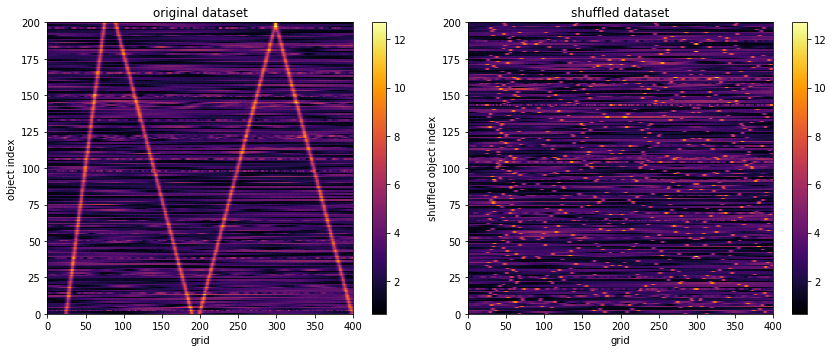

In [9]:
# shuffle the original dataset, and produce a plot showing the original dataset and the shuffled version
indices = numpy.arange(len(objects_list))
numpy.random.shuffle(indices)
objects_list_shuffled = objects_list[indices, :]

plt.figure(1, figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("original dataset")
plt.pcolormesh(objects_list, cmap="inferno")
plt.xlabel("grid")
plt.ylabel("object index")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("shuffled dataset")
plt.pcolormesh(objects_list_shuffled, cmap="inferno")
plt.xlabel("grid")
plt.ylabel("shuffled object index")
plt.colorbar()

plt.tight_layout()

## Figure of merit for the one-dimensional embedding by Dimensionality Reduction algorithms
The result of many Dimensionality Reduction techniques depends on the assumed distance metric between the objects in the sample and on several hyper-parameters. Such algorithms lack a figure of merit with which these parameters can be optimized, and thus a large fraction of the data exploration process is devoted to finding the best distance metric and set of hyper-parameters, where "best" is very subjective and often requires domain knowledge. In addition, lacking a clear figure of merit, it is difficult to compare between the outputs of different Dimensionality reduction algorithms.<br>

In our paper (Baron & Ménard 2020), we suggested a general figure of merit that can be used to optimzie over the hyper-parameters of any Dimensionality Reduction algorithm, if what we're interested in is a sequence (that is, a one dimensional trend). Similarly to the Sequencer, we can define the graph's axis ratio of the resulting one-dimensional embedding, and use it as a figure of merit. This axis ratio can be used to select the "best" distance metric and hyper-parameters of algirithms such as tSNE and UMAP. 

### Defining the axis ratio of the one-dimensional embedding by tSNE and UMAP
We define the normalized axis ratio of the resulting embedding by tSNE/UMAP as follows. Given a chosen distance metric and hyper-parameters, we apply tSNE/UMAP to the dataset to embed it into a two-dimensional space. We then calculate the geometrical axis ratio spanned by the points in this space: using the assigned coordinates in the two-dimensional space, we calculate the distance matrix between the objects in the sample, assuming Euclidean distance. The resulting distance matrix is a fully-connected graph, and we can estimate its Minimum Spanning Tree (MST). Similarly to the Sequencer, we estimate the axis ratio of the resulting MST. The normalized axis ratio is then defined as the MST axis ratio, divided by the number of objects in the sample, $N$. The normalized axis ratio ranges from 1 (a perfect sequence: a 1D line embedded in a 2D space) to $1/N$ (no sequence), and it represents the elongation of the resulting embedding of the objects in the two-dimensional space. A similar method cannot be applied to the embedding in the one-dimensional space, since, by construction, the normalized axis ratio spanned by points in 1D will always be 1. Therefore, although the final sequence by tSNE/UMAP is obtained from the one-dimensional embedding of the input dataset, the axis ratio is calculated using the two-dimensional embedding. That is, the axis ratio of the two-dimensional embedding represents the degree of divergence of the representation from a one-dimensional line. The resulting axis ratio can serve as a figure of merit of the resulting embedding in 1D only if the two embeddings are not dramatically different from each other. Throughout our experiments, we found a high degree of correlation between the 1D and 2D embeddings by tSNE and UMAP. Therefore, we suggest that the 2D axis ratio can be used as a figure of merit of the final 1D embedding. <br><br>

The following cell contains the function with which one can estimate the axis ratio of a two-dimensional embedding. The next cells contain functions that apply tSNE and UMAP to an input dataset. The functions vary the hyper-parameters of the algorithms and output the one-dimensional embedding that results in the best axis ratio. 

In [12]:
# define the function with which you will estimate the axis ratio of the embedding
# this function will use several additional functions given in the file axis_ratio_estimation.py

import axis_ratio_estimation

def return_axis_ratio_of_2D_embedding(y):
    """Function estimates the axis ratio of the given two-dimensional embedding. 
    
    Parameters
    -------
    :param y: numpy.ndarray() of shape (N, 2), where N is the number of objects in the sample. 
        This array represents the two-dimensional embedding of the objects in the sample by algorithms
        such as tSNE and UMAP.
        
    Returns
    -------
    :param axis_ratio_normalized: float, the normalized axis ratio of the two-dimensional embedding
    """
    distance_matrix = numpy.zeros((len(y), len(y)))
    for i in range(len(y)):
        for j in range(len(y)):
            d = numpy.sum((y[i] - y[j])**2)
            distance_matrix[i, j] = d
    
    G, mst_axis_ratio = axis_ratio_estimation.apply_MST_and_return_MST_and_axis_ratio(distance_matrix)
    axis_ratio_normalized = mst_axis_ratio / float(len(y))
    return axis_ratio_normalized

Define two functions that apply tSNE and UMAP to an input dataset. These functions will examine various hyper-parameters and two different distance metrics. The output of the functions will be the one-dimensional embedding that resulted in the largest axis ratio. 

In [18]:
def apply_tsne_to_dataset(grid, objects_list, learning_rate_list, perplexity_list):
    """Function applies tSNE to the input dataset and returns its "best" one-dimensional embedding.
    The function takes as an input a list of learning rates and perplexities (which are the two main 
    hyper-parameters of tSNE), and selects the learning rate and perplexity that result in the largest 
    axis ratio of the one-dimensional embedding. The function also considers two distance metrics: the Euclidean
    Distance and the EMD. 
    
    Parameters
    -------
    :param grid: numpy.ndarray(), the x-axis of the objects in the sample.
    :param objects_list: numpy.ndarray(), the list of the objects to embed in 1D.
    :param learning_rate_list: a list of learning rates to consider during the optimization.
    :param perplexity_list: a list of perplexities to consider during the optimization
    
    Returns
    -------
    :param axis_ratio_best: float, the largest axis ratio obtained for the dataset
    :param metric_best: string, the distance metric that resulted in the largest axis ratio
    :param perplexity_best: integer, the perplexity that resulted in the largest axis ratio
    :param learning_rate_best: integer, the learning rate that resulted in the largest axis ratio
    :param one_d_embedding_best: numpy.ndarray(), the one-dimensional embedding that resulted in the largest axis ratio
    """
    metrics_all = []
    learning_rates_all = []
    perplexities_all = []
    axis_ratios_all = []
    one_d_embeddings_all = []
    
    # step 1: start with the Euclidean distance, examine all the hyper-parameters
    for i, learning_rate_value in enumerate(learning_rate_list):
        for j, perplexity_value in enumerate(perplexity_list):
       
            # 1D embedding by tSNE, for the sequence
            tsne = TSNE(n_components=1, init='random', random_state=0, 
                        perplexity=perplexity_value, learning_rate=learning_rate_value)
            y = tsne.fit_transform(objects_list).flatten()
            
            # 2D embedding by tSNE, for the axis ratio score
            tsne2 = TSNE(n_components=2, init='random', random_state=0, 
                        perplexity=perplexity_value, learning_rate=learning_rate_value)
            y2 = tsne2.fit_transform(objects_list)
            axis_ratio = return_axis_ratio_of_2D_embedding(y2)
            
            # add these to the list
            metrics_all.append('L2')
            learning_rates_all.append(learning_rate_value)
            perplexities_all.append(perplexity_value)
            axis_ratios_all.append(axis_ratio)
            one_d_embeddings_all.append(y)

    # step 2: compute the EMD distance matrix, and examine all the hyper-parameters
    N = len(objects_list)
    x = numpy.copy(grid)
    distance_matrix = numpy.zeros((N, N))
    for i in range(N):
        for j in range(i, N):
            obj_i = objects_list[i]
            obj_j = objects_list[j]
            dist = wasserstein_distance(grid, grid, u_weights=obj_i, v_weights=obj_j)
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    for i, learning_rate_value in enumerate(learning_rate_list):
        for j, perplexity_value in enumerate(perplexity_list):

            # 1D embedding by tSNE, for the sequence
            tsne = TSNE(n_components=1, init='random', random_state=0, 
                        perplexity=perplexity_value, learning_rate=learning_rate_value, 
                        metric="precomputed")
            y = tsne.fit_transform(distance_matrix).flatten()
            
            # 2D embedding by tSNE, for the axis ratio score
            tsne2 = TSNE(n_components=2, init='random', random_state=0, 
                        perplexity=perplexity_value, learning_rate=learning_rate_value, 
                        metric="precomputed")
            y2 = tsne2.fit_transform(distance_matrix)
            axis_ratio = return_axis_ratio_of_2D_embedding(y2)
            
            # add these to the list
            metrics_all.append('EMD')
            learning_rates_all.append(learning_rate_value)
            perplexities_all.append(perplexity_value)
            axis_ratios_all.append(axis_ratio)
            one_d_embeddings_all.append(y)

    # find the best embedding according to the axis ratio
    best_axis_ratio_index = numpy.argmax(axis_ratios_all)
    
    axis_ratio_best = axis_ratios_all[best_axis_ratio_index]
    metric_best = metrics_all[best_axis_ratio_index]
    perplexity_best = perplexities_all[best_axis_ratio_index]
    learning_rate_best = perplexities_all[best_axis_ratio_index]
    one_d_embedding_best = one_d_embeddings_all[best_axis_ratio_index]

    return axis_ratio_best, metric_best, perplexity_best, learning_rate_best, one_d_embedding_best

In [30]:
def return_EMD_distance(vec_1, vec_2):
    """
    the funciton returns the EMD distance between the two vectors
    """
    grid = numpy.arange(len(vec_1))
    dist = wasserstein_distance(grid, grid, u_weights=vec_1, v_weights=vec_2)
    return dist

def apply_umap_to_dataset(grid, objects_list, n_neighbor_list, min_dist_list):
    """Function applies UMAP to the input dataset and returns its "best" one-dimensional embedding.
    The function takes as an input a list of n_neighbor and min_dist (which are the two main 
    hyper-parameters of UMAP), and selects the parameters that result in the largest axis ratio of 
    the one-dimensional embedding. The function also considers two distance metrics: the Euclidean
    Distance and the EMD. 
    
    Parameters
    -------
    :param grid: numpy.ndarray(), the x-axis of the objects in the sample.
    :param objects_list: numpy.ndarray(), the list of the objects to embed in 1D.
    :param n_neighbor_list: a list of n_neighbor to consider during the optimization.
    :param min_dist_list: a list of min_dist to consider during the optimization
    
    Returns
    -------
    :param axis_ratio_best: float, the largest axis ratio obtained for the dataset
    :param metric_best: string, the distance metric that resulted in the largest axis ratio
    :param n_neighbor_best: integer, the n_neighbor that resulted in the largest axis ratio
    :param min_dist_best: float, the min_dist that resulted in the largest axis ratio
    :param one_d_embedding_best: numpy.ndarray(), the one-dimensional embedding that resulted in the largest axis ratio
    """
    metrics_all = []
    n_neighbor_all = []
    min_dist_all = []
    axis_ratios_all = []
    one_d_embeddings_all = []
    
    # step 1: start with the Euclidean distance, examine all the hyper-parameters
    for i, n_neighbor_value in enumerate(n_neighbor_list):
        for j, min_dist_value in enumerate(min_dist_list):
       
            # 1D embedding by UMAP, for the sequence
            reducer = umap.UMAP(random_state=42, n_neighbors=n_neighbor_value, 
                                min_dist=min_dist_value, n_components=1)
            y = reducer.fit_transform(objects_list).flatten()
            
            # 2D embedding by UMAP, for the axis ratio score
            reducer2 = umap.UMAP(random_state=42, n_neighbors=n_neighbor_value, 
                                 min_dist=min_dist_value, n_components=2)
            y2 = reducer2.fit_transform(objects_list)
            axis_ratio = return_axis_ratio_of_2D_embedding(y2)
            
            # add these to the list
            metrics_all.append('L2')
            n_neighbor_all.append(n_neighbor_value)
            min_dist_all.append(min_dist_value)
            axis_ratios_all.append(axis_ratio)
            one_d_embeddings_all.append(y)

    # step 2: examine the EMD, and examine all the hyper-parameters

    for i, n_neighbor_value in enumerate(n_neighbor_list):
        for j, min_dist_value in enumerate(min_dist_list):

            # 1D embedding by UMAP, for the sequence
            reducer = umap.UMAP(random_state=42, n_neighbors=n_neighbor_value, 
                                min_dist=min_dist_value, n_components=1, 
                                metric=return_EMD_distance)
            y = reducer.fit_transform(objects_list).flatten()
            
            # 2D embedding by UMAP, for the axis ratio score
            reducer2 = umap.UMAP(random_state=42, n_neighbors=n_neighbor_value, 
                                 min_dist=min_dist_value, n_components=2,
                                 metric=return_EMD_distance)
            y2 = reducer2.fit_transform(objects_list)
            axis_ratio = return_axis_ratio_of_2D_embedding(y2)
            
            # add these to the list
            metrics_all.append('L2')
            n_neighbor_all.append(n_neighbor_value)
            min_dist_all.append(min_dist_value)
            axis_ratios_all.append(axis_ratio)
            one_d_embeddings_all.append(y)

    # find the best embedding according to the axis ratio
    best_axis_ratio_index = numpy.argmax(axis_ratios_all)
    
    axis_ratio_best = axis_ratios_all[best_axis_ratio_index]
    metric_best = metrics_all[best_axis_ratio_index]
    n_neighbor_best = n_neighbor_all[best_axis_ratio_index]
    min_dist_best = min_dist_all[best_axis_ratio_index]
    one_d_embedding_best = one_d_embeddings_all[best_axis_ratio_index]

    return axis_ratio_best, metric_best, n_neighbor_best, min_dist_best, one_d_embedding_best

## 3. Comparison between the Sequencer and tSNE and UMAP
In this part of the notebook I will apply the Sequencer, tSNE, and UMAP, to look for a one-dimensional trend in the simulated dataset. The Sequencer will be applied with its default settings. I will then apply tSNE and UMAP and will examine a set of possible hyper-parameters. I will use the best one-dimensional embedding by tSNE and UMAP to estimate the detected sequence by these two algorithms.<br>

1. **Apply the Sequencer to the dataset:**

In [35]:
# apply the Sequencer to this data
estimator_list = ['EMD', 'energy', 'KL', 'L2']
seq = sequencer.Sequencer(grid, objects_list_shuffled, estimator_list)
output_path = "sequencer_output_directory"
final_axis_ratio, final_sequence = seq.execute(output_path, to_average_N_best_estimators=True,
                                               number_of_best_estimators=3)

print("resulting axis ratio for the Sequencer: ", final_axis_ratio)

calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 2.834235906600952 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 4.76894211769104 seconds
calculating the distance matrices for estimator: EMD, scale: 4
finished calculating this distance matrix list, it took: 7.284403085708618 seconds
calculating the distance matrices for estimator: EMD, scale: 8
finished calculating this distance matrix list, it took: 13.262265682220459 seconds
calculating the distance matrices for estimator: EMD, scale: 16
finished calculating this distance matrix list, it took: 24.965676069259644 seconds
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 2.7667150497436523 seconds
calculating the distance matrices for estimator: energy, scale: 2
finished calculating this distance matrix list, it t

../code/sequencer.py:937: RuntimeWarning: divide by zero encountered in true_divide
  numpy.fill_diagonal(proximity_matrix_copy, numpy.inf)


dumped the sparse distance matrix to the file: <_io.BufferedWriter name='sequencer_output_directory/sparse_distance_matrix.pkl'>
dumped the final sequences and axis ratio to the file: <_io.BufferedWriter name='sequencer_output_directory/final_products.pkl'>
resulting axis ratio for the Sequencer:  58.5209


In [37]:
# print all the metrics and scales, and examine the intermediate axis ratios 
estimator_list, scale_list, axis_ratio_list = seq.return_axis_ratio_of_weighted_products_all_metrics_and_scales()

print("intermediate axis ratios for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, axis ratio: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   numpy.round(axis_ratio_list[i], 2)))

intermediate axis ratios for the different metrics and scales:
metric=EMD, scale=1, axis ratio: 10.29
metric=EMD, scale=2, axis ratio: 6.39
metric=EMD, scale=4, axis ratio: 5.43
metric=EMD, scale=8, axis ratio: 8.48
metric=EMD, scale=16, axis ratio: 16.7
metric=energy, scale=1, axis ratio: 11.6
metric=energy, scale=2, axis ratio: 9.58
metric=energy, scale=4, axis ratio: 5.43
metric=energy, scale=8, axis ratio: 10.52
metric=energy, scale=16, axis ratio: 21.68
metric=KL, scale=1, axis ratio: 6.05
metric=KL, scale=2, axis ratio: 9.05
metric=KL, scale=4, axis ratio: 25.2
metric=KL, scale=8, axis ratio: 39.14
metric=KL, scale=16, axis ratio: 54.65
metric=L2, scale=1, axis ratio: 8.35
metric=L2, scale=2, axis ratio: 23.02
metric=L2, scale=4, axis ratio: 31.8
metric=L2, scale=8, axis ratio: 38.56
metric=L2, scale=16, axis ratio: 58.52


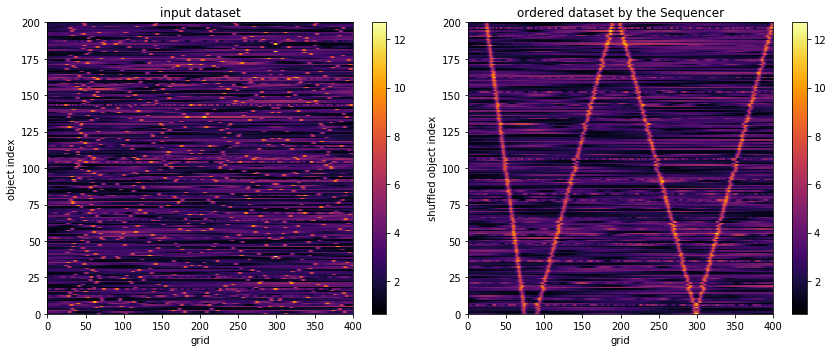

In [38]:
# reorder the objects according to the detected sequence, and plot the result

objects_list_ordered_by_sequencer = objects_list_shuffled[final_sequence, :]

plt.figure(1, figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled, cmap="inferno")
plt.xlabel("grid")
plt.ylabel("object index")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("ordered dataset by the Sequencer")
plt.pcolormesh(objects_list_ordered_by_sequencer, cmap="inferno")
plt.xlabel("grid")
plt.ylabel("shuffled object index")
plt.colorbar()

plt.tight_layout()

2. **Apply tSNE to the dataset:**

In [39]:
# apply tSNE with a grid of hyper-parameters
learning_rate_list = [50, 100, 150]
perplexity_list = [50, 100, 150]
normalized_axis_ratio_tsne_best, metric_tsne_best, perplexity_tsne_best, learning_rate_tsne_best, one_d_embedding_tsne_best = apply_tsne_to_dataset(grid, objects_list_shuffled, learning_rate_list, perplexity_list)

# the axis ratio returned by the function is a normalized axis ratio, calculate the original axis ratio as well
axis_ratio_tsne_best = normalized_axis_ratio_tsne_best * len(objects_list_shuffled)
print("Best axis ratio obtained with tSNE: %s" % axis_ratio_tsne_best)
print("Best metric: %s, perplexity: %s, learning rate: %s" % (metric_tsne_best,
                                                              perplexity_tsne_best,
                                                              learning_rate_tsne_best))

Best axis ratio obtained with tSNE: 44.988249999999994
Best metric: EMD, perplexity: 100, learning rate: 100


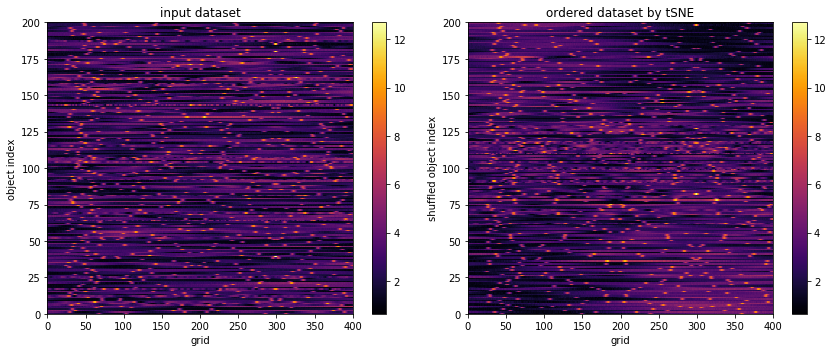

In [40]:
# obtain the sequence by tSNE by rank-ordering the best one-dimensional embedding by tSNE
sequence_by_tsne = numpy.argsort(one_d_embedding_tsne_best)

# reorder the objects according to the detected sequence by tSNE, and plot the results
objects_list_ordered_by_tsne = objects_list_shuffled[sequence_by_tsne, :]

plt.figure(1, figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled, cmap="inferno")
plt.xlabel("grid")
plt.ylabel("object index")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("ordered dataset by tSNE")
plt.pcolormesh(objects_list_ordered_by_tsne, cmap="inferno")
plt.xlabel("grid")
plt.ylabel("shuffled object index")
plt.colorbar()

plt.tight_layout()

3. **Apply UMAP to the dataset:**

In [41]:
# apply tSNE with a grid of hyper-parameters
n_neighbor_list = [50, 100, 150]
min_dist_list = [0.1, 0.2, 0.5, 0.8]
normalized_axis_ratio_umap_best, metric_umap_best, n_neighbor_umap_best, min_dist_umap_best, one_d_embedding_umap_best = apply_umap_to_dataset(grid, objects_list_shuffled, n_neighbor_list, min_dist_list)

# the axis ratio returned by the function is a normalized axis ratio, calculate the original axis ratio as well
axis_ratio_umap_best = normalized_axis_ratio_umap_best * len(objects_list_shuffled)
print("Best axis ratio obtained with UMAP: %s" % axis_ratio_umap_best)
print("Best metric: %s, n_neighbor: %s, min_dist: %s" % (metric_umap_best,
                                                         n_neighbor_umap_best,
                                                         min_dist_umap_best))

Best axis ratio obtained with UMAP: 42.84265
Best metric: L2, n_neighbor: 150, min_dist: 0.5


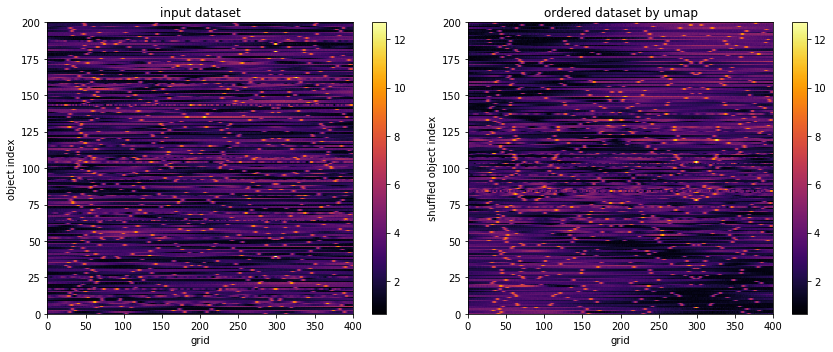

In [42]:
# obtain the sequence by UMAP by rank-ordering the best one-dimensional embedding by UMAP
sequence_by_umap = numpy.argsort(one_d_embedding_umap_best)

# reorder the objects according to the detected sequence by tSNE, and plot the results
objects_list_ordered_by_umap = objects_list_shuffled[sequence_by_umap, :]

plt.figure(1, figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled, cmap="inferno")
plt.xlabel("grid")
plt.ylabel("object index")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("ordered dataset by umap")
plt.pcolormesh(objects_list_ordered_by_umap, cmap="inferno")
plt.xlabel("grid")
plt.ylabel("shuffled object index")
plt.colorbar()

plt.tight_layout()

### Compare the reordered datasets by the Sequencer, tSNE, and UMAP
Below, I will plot the reordered datasets according to the sequences detected by each of the algorithms. <br>
I will list the axis ratio that is assocciated with each of the detected sequences. <br>
For tSNE and UMAP, I will also indicate the hyper-parameters and metrics that resulted in the best embedding.

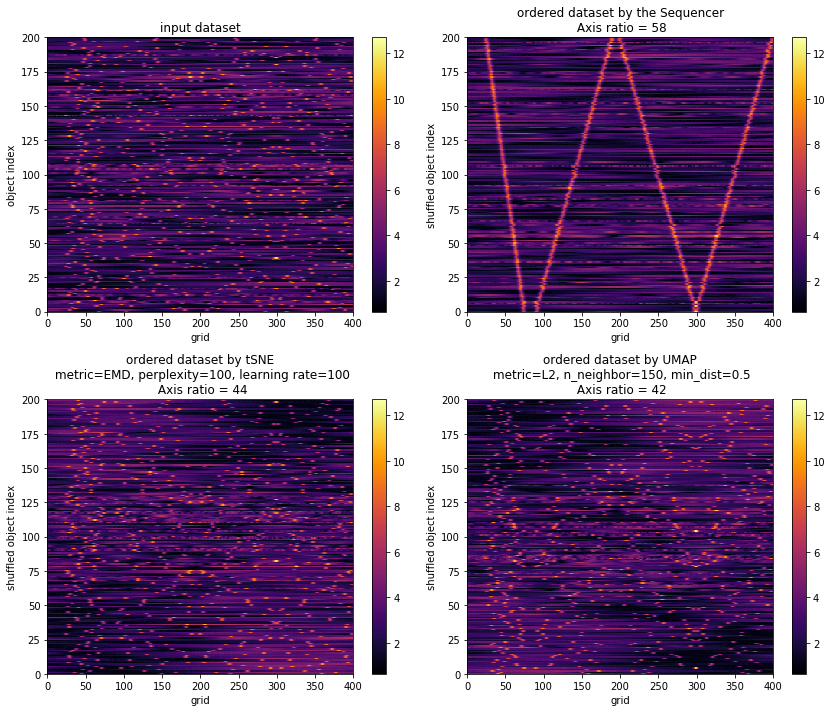

In [47]:
plt.figure(1, figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled, cmap="inferno")
plt.xlabel("grid")
plt.ylabel("object index")
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title("ordered dataset by the Sequencer\n Axis ratio = %s" % int(final_axis_ratio))
plt.pcolormesh(objects_list_ordered_by_sequencer, cmap="inferno")
plt.xlabel("grid")
plt.ylabel("shuffled object index")
plt.colorbar()

plt.subplot(2, 2, 3)
plt.title("ordered dataset by tSNE\n metric=%s, perplexity=%s, learning rate=%s\n Axis ratio = %s" % (metric_tsne_best, 
                                                                                                      perplexity_tsne_best,
                                                                                                      learning_rate_tsne_best,
                                                                                                      int(axis_ratio_tsne_best)))
plt.pcolormesh(objects_list_ordered_by_tsne, cmap="inferno")
plt.xlabel("grid")
plt.ylabel("shuffled object index")
plt.colorbar()
                                                   

plt.subplot(2, 2, 4)
plt.title("ordered dataset by UMAP\n metric=%s, n_neighbor=%s, min_dist=%s\n Axis ratio = %s" % (metric_umap_best, 
                                                                                                 n_neighbor_umap_best,
                                                                                                 min_dist_umap_best,
                                                                                                 int(axis_ratio_umap_best)))
plt.pcolormesh(objects_list_ordered_by_umap, cmap="inferno")
plt.xlabel("grid")
plt.ylabel("shuffled object index")
plt.colorbar()


plt.tight_layout()

### Summary: 
One can clearly see that the Sequencer succeffully identified the one-dimensional trend in narrow pulse location, although these pulses constitute a small fraction of the total integrated intensity in each object. The success of the Sequencer in identifying the one-dimensional trend is a direct result of our multi-scale approach: since the Sequencer tries to find the most elongated manifold in the dataset, and in this case the most elongated manifold is on small scales, the Sequencer gave a larger weight to small scales. <br>
Contrary to the Sequencer, both tSNE and UMAP identified a weaker trend in the large-scale fluctuations and completely missed the one-dimensional trend in narrow pulse location. We can see that the resulting axis ratios of the one-dimensional embeddings are smaller than the axis ratio obtained by the Sequencer. 